# **AI-generation of desired aerodynamic performance airfoil geometries using AirfRANS dataset**

 🧠 **Core Idea** : We want to create a pipeline that will generate new NACA airfoils geometries. These newly AI-generated geometries  that will have the aerodynamic performance of our choice in terms of forces and pressure distribution for given angles of attack and Reynolds numbers.

Step 1️⃣: We want to train an autoencoder on airfoil geometries to capture the distribution of shapes in a latent space.

Step 2️⃣: Then we want to train an inverse neural network that will map the aerodynamic performance of the NACA airfoils onto their respective latent geometries.

Step 3️⃣: We then generate our ideal set of performance parameters and pass them through the inverse NN which will yield a new latent space geometry that will be translated back to original euclidian geometry space by the decoder of the autoencoder. Ideally this NACA computer-generated airfoil will have the performance that we thought about initially.


### 🚀 Pipeline

#### 1️⃣ Getting the AirfRANS Data  
The dataset is extracted from CFD simulations in two steps:

- **Step 1:** Extract the NACA airfoil contours (pairs of points $(x, y)$) together with the corresponding pressure distribution.  
- **Step 2:** Extract the aerodynamic performance quantities — lift, drag, moment coefficients, forces, angle of attack, and Reynolds number.

---

#### 2️⃣ Build and Train the Autoencoder (Using CST Coefficients)

Instead of raw $(x,y)$ coordinates, each airfoil is represented using **CST (Class–Shape Transformation) coefficients**:

- Upper surface: $N_{\text{CST}} + 1 = 9$ coefficients  
- Lower surface: $9$ coefficients  
- **Total input dimension:**  
  $$18\ \text{CST coefficients per airfoil}$$
By using CST coefficients and a compressed latent space, the inverse network learns how to generate **realistic airfoils** that match target aerodynamic properties, while the decoder ensures the output stays on the manifold of **valid and smooth** airfoil geometries.

These 18 parameters go into the autoencoder:

**Encoder:**  
Compresses the 18 CST coefficients into a low-dimensional latent vector $z$:

$$
z = f_{\text{enc}}(\text{CST}_{18})
$$

**Decoder:**  
Reconstructs the CST coefficients from the latent code:

$$
\widehat{\text{CST}} = f_{\text{dec}}(z)
$$

This builds a **latent manifold of valid airfoil shapes**.  

---

#### 3️⃣ Build and Train the Inverse Network

Once the autoencoder is fully trained and **frozen**, a second network is trained:

$$
\left[\, F_{\text{tot}X},\ F_{\text{tot}Y},\ C_D,\ C_L,\ C_M,\ Re,\ AoA,\ p_{\text{distribution}}\,\right]
\;\xrightarrow{\,f_{\text{inv}}\,}\;
z
$$



This inverse model learns how aerodynamic targets map to appropriate latent codes.

---

#### 4️⃣ Create a New Aerodynamic Target Vector  
You choose a desired performance vector, for example:

$$
\left[\, F_{\text{tot}X}^{\ast},\ F_{\text{tot}Y}^{\ast},\ C_D^{\ast},\ C_L^{\ast},\ C_M^{\ast},\ Re,\ AoA,\ p_{\text{distribution}}^{\ast}\,\right]
$$

---

#### 5️⃣ Pass the Target Through the Inverse Network  
The inverse model outputs a latent vector:

$$
z^{\ast} = f_{\text{inv}}(\left[\, F_{\text{tot}X}^{\ast},\ F_{\text{tot}Y}^{\ast},\ C_D^{\ast},\ C_L^{\ast},\ C_M^{\ast},\ Re,\ AoA,\ p_{\text{distribution}}^{\ast}\,\right])
$$

---

#### 6️⃣ Decode the Latent Code into CST Coefficients  
Using the decoder:

$$
\widehat{\text{CST}}^{\ast} = f_{\text{dec}}(z^{\ast})
$$

These CST coefficients represent a new, AI-generated airfoil shape.

---

#### 7️⃣ Reconstruct and Plot the New Airfoil  
Use the CST reconstruction formula to map the coefficients back to smooth $(x,y)$ coordinates, plot the geometry, and analyze the resulting shape.




### Importing python modules

In [7]:
import pandas as pd
import numpy as np
from math import comb
from pathlib import Path
import airfrans as af
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from typing import List, Sequence, Optional, Tuple, Union
from typing import Iterable, Optional, Dict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#pytorch utilities
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

### 🇦 Getting the AirfRANS dataset

In [8]:
DATA_DIR = Path(r"D:\data_airfrans")
DATA_DIR_UNPACKED = DATA_DIR / "Dataset"
DATA_DIR.mkdir(parents=True, exist_ok=True)


# Pre-processed data (VTU/VTP). Set OpenFOAM=True for raw OpenFOAM files.
#af.dataset.download(root=str(DATA_DIR), file_name="Dataset", unzip=True, OpenFOAM=False)

In [9]:
# task ∈ {'full', 'scarce', 'reynolds', 'aoa'}, train=True/False
dataset_list, dataset_names = af.dataset.load(root=str(DATA_DIR_UNPACKED), task="scarce", train=True)

len(dataset_list), dataset_names[:3]


Loading dataset (task: scarce, split: train): 100%|██████████████████████████████████| 200/200 [02:58<00:00,  1.12it/s]


(200,
 ['airFoil2D_SST_36.622_11.319_3.941_5.424_1.0_16.283',
  'airFoil2D_SST_58.831_-3.563_2.815_4.916_10.078',
  'airFoil2D_SST_43.327_8.905_4.236_6.511_10.744'])

### 🇧 Exploring the dataset

In [10]:
#how to read the cases names :

# airFoil2D_SST_<U_in>_<alpha>_<p₁>_<p₂>_<p₃>[_<p₄>]
# where p1, p2 and p3 are the maximum camber m-(% of chord), position of maximum camber (p-% of chord) and maximum thickness (t-% of chord) for NACA 4-digit
# where p1, p2, p3 and p4 are the parameters for NACA 5-digit (cl_design, p, reflex_flag, t). they might be float.

In [11]:
len(dataset_list)

200

In [12]:
type(dataset_list)

list

In [13]:
i = 1  # or: i = dataset_names.index("<exact case name>")
arr = dataset_list[i]

# Columns per AirfRANS docs:
# 7 features: (x, y), inlet velocity (u_in, v_in), distance-to-airfoil d, normals (nx, ny)
# 4 targets:  velocity (u, v), pressure/ρ (p_over_rho), turbulent kinematic viscosity (nu_t)
# 1 flag:     on_airfoil (bool)
cols = [
    "x", "y",
    "u_in", "v_in",
    "d",
    "nx", "ny",
    "u", "v",
    "p_over_rho", "nu_t",
    "on_airfoil"
]

df = pd.DataFrame(arr, columns=cols)
df["on_airfoil"] = df["on_airfoil"].astype(bool)

print("Case:", dataset_names[i])
print("Shape:", df.shape)
df.head(20)  # show first 20 rows

Case: airFoil2D_SST_58.831_-3.563_2.815_4.916_10.078
Shape: (170180, 12)


,x,y,u_in,v_in,d,nx,ny,u,v,p_over_rho,nu_t,on_airfoil
0,4.216870,-0.199916,58.717284,-3.656112,3.223076,0.0,0.0,54.545265,-3.353434,2.491901,0.007009,False
1,4.216889,-0.199935,58.717284,-3.656112,3.223097,0.0,0.0,54.544991,-3.353404,2.491885,0.007009,False
2,3.991839,-0.185931,58.717284,-3.656112,2.997611,0.0,0.0,54.389606,-3.343191,2.857927,0.007033,False
3,3.991858,-0.185950,58.717284,-3.656112,2.997631,0.0,0.0,54.389282,-3.343161,2.857906,0.007033,False
4,3.782508,-0.172922,58.717284,-3.656112,2.787876,0.0,0.0,54.228321,-3.332824,3.269879,0.007054,False
5,3.782527,-0.172940,58.717284,-3.656112,2.787896,0.0,0.0,54.227970,-3.332792,3.269851,0.007054,False
6,3.587782,-0.160820,58.717284,-3.656112,2.592774,0.0,0.0,54.061207,-3.322358,3.732441,0.007073,False
7,3.587800,-0.160839,58.717284,-3.656112,2.592793,0.0,0.0,54.060833,-3.322320,3.732408,0.007073,False
8,3.406641,-0.149563,58.717284,-3.656112,2.411284,0.0,0.0,53.888069,-3.311814,4.250607,0.007089,False
9,3.406658,-0.149581,58.717284,-3.656112,2.411302,0.0,0.0,53.887646,-3.311771,4.250566,0.007089,False


In [14]:

arr = dataset_list[0]

cols = ["x","y","u_in","v_in","d","nx","ny","u","v","p_over_rho","nu_t","on_airfoil"]

mask = arr[:, 11].astype(bool)
arr_on = arr[mask]
df_on = pd.DataFrame(arr_on, columns=cols)


In [15]:

# choose a case
i = 0  # or: i = dataset_names.index("<exact case name>")

arr = dataset_list[i]
cols = ["x","y","u_in","v_in","d","nx","ny","u","v","p_over_rho","nu_t","on_airfoil"]
df = pd.DataFrame(arr, columns=cols)
df["on_airfoil"] = df["on_airfoil"].astype(bool)

print("Case:", dataset_names[i], " | points:", len(df))


Case: airFoil2D_SST_36.622_11.319_3.941_5.424_1.0_16.283  | points: 181794


In [16]:
counts_per_matrix = [int(np.count_nonzero(M[:, -1])) for M in dataset_list]

In [17]:
counts_per_matrix

[1025,
 944,
 896,
 1020,
 1079,
 1014,
 1014,
 1011,
 1012,
 1063,
 1042,
 1019,
 1025,
 997,
 1105,
 1067,
 1001,
 1011,
 998,
 973,
 990,
 973,
 1018,
 1001,
 1019,
 1000,
 1015,
 1006,
 1008,
 1007,
 982,
 976,
 1019,
 992,
 862,
 1027,
 1051,
 1028,
 1015,
 1010,
 891,
 1062,
 1016,
 1011,
 1014,
 1027,
 1010,
 936,
 1010,
 1089,
 1009,
 1019,
 1147,
 968,
 1027,
 1012,
 969,
 1022,
 1070,
 1051,
 865,
 1011,
 925,
 1056,
 952,
 927,
 1026,
 1007,
 1027,
 1010,
 1023,
 874,
 887,
 1029,
 1003,
 1025,
 1016,
 1101,
 1022,
 1033,
 982,
 1052,
 875,
 1031,
 994,
 1028,
 1025,
 1010,
 1005,
 1039,
 1051,
 1016,
 1001,
 1017,
 1016,
 979,
 1095,
 1013,
 1033,
 1011,
 997,
 932,
 1004,
 1022,
 1013,
 1011,
 1023,
 1028,
 1018,
 1031,
 1003,
 1129,
 888,
 1024,
 995,
 1013,
 888,
 1075,
 1018,
 951,
 1014,
 1042,
 1015,
 881,
 1012,
 1062,
 1029,
 1009,
 1000,
 1014,
 992,
 1034,
 1020,
 1039,
 1020,
 1032,
 1104,
 1039,
 1038,
 1008,
 988,
 978,
 949,
 1007,
 1026,
 1020,
 1024,
 1027,


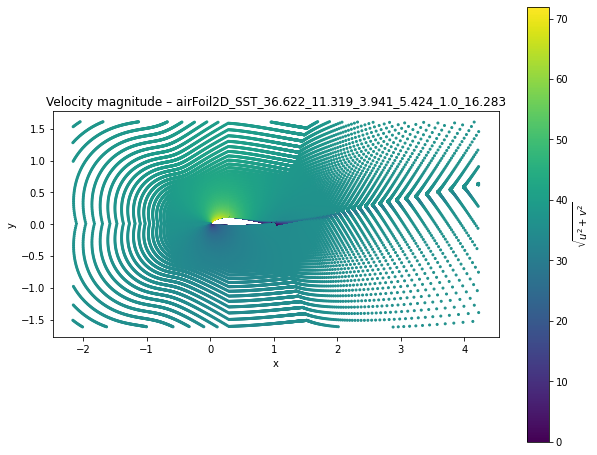

In [18]:
velocity = np.hypot(df["u"], df["v"])

plt.figure(figsize=(10,8))
plt.scatter(df["x"], df["y"], c=velocity, s=4)
plt.gca().set_aspect("equal", adjustable="box")
plt.xlabel("x"); plt.ylabel("y"); plt.title(f"Velocity magnitude – {dataset_names[i]}")
plt.colorbar(label=r"$\sqrt{u^2 + v^2}$")
plt.show()


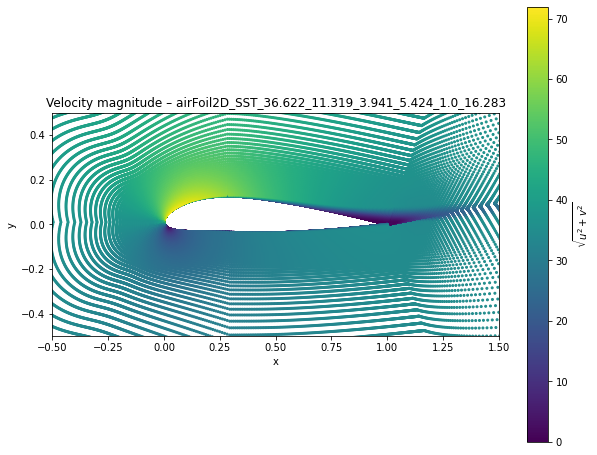

In [19]:
velocity = np.hypot(df["u"], df["v"])

plt.figure(figsize=(10,8))
plt.scatter(df["x"], df["y"], c=velocity, s=4)
plt.gca().set_aspect("equal", adjustable="box")
plt.xlabel("x"); plt.ylabel("y"); plt.title(f"Velocity magnitude – {dataset_names[i]}")
plt.colorbar(label=r"$\sqrt{u^2 + v^2}$")
plt.xlim(-0.5,1.5)
plt.ylim(-0.5,0.5)
plt.show()


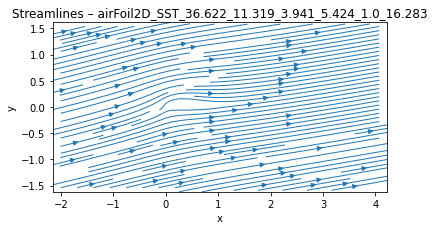

In [20]:
# grid to interpolate onto
x_i = np.linspace(df["x"].min(), df["x"].max(), 300)
y_i = np.linspace(df["y"].min(), df["y"].max(), 200)
xx, yy = np.meshgrid(x_i, y_i)

U = griddata((df["x"], df["y"]), df["u"], (xx, yy), method="linear")
V = griddata((df["x"], df["y"]), df["v"], (xx, yy), method="linear")

plt.figure(figsize=(6,5))
# streamplot expects 1D x/y axes and 2D U,V on the mesh
plt.streamplot(x_i, y_i, U, V, density=1.4, linewidth=1)
plt.gca().set_aspect("equal", adjustable="box")
plt.xlabel("x"); plt.ylabel("y"); plt.title(f"Streamlines – {dataset_names[i]}")
plt.show()


### 🇨 Get only the surface points from the dataset

In [21]:
#this function takes one pandas df, selects only the on_airfoil 1 values and returns the result of that particular df
def select_surface_points(df_case: pd.DataFrame) -> pd.DataFrame:
    """
    Return only the airfoil-surface points from one case.

    We accept either boolean True/False or 1/0 in the `on_airfoil` column.
    Raises a clear error if no surface points are found.
    """
    if "on_airfoil" not in df_case.columns:
        raise KeyError("Column 'on_airfoil' not found in the DataFrame.")

    # Accept both bool and {0,1}
    mask = (df_case["on_airfoil"] == 1) | (df_case["on_airfoil"] == True)
    df_surface = df_case.loc[mask].copy()

    if df_surface.empty:
        raise ValueError("No surface points found (on_airfoil==1/True).")

    # Optional: keep only the columns we’ll need downstream
    keep_cols = [c for c in ["x","y","u","v","p_over_rho","nu_t","u_in","v_in","nx","ny","d","on_airfoil"] if c in df_surface.columns]
    df_surface = df_surface[keep_cols]

    return df_surface


def batch_select_surface_points(
    arrays: Sequence[np.ndarray],
    columns: Optional[Sequence[str]] = None,
    return_numpy: bool = False
) -> List[Union[pd.DataFrame, np.ndarray]]:
    """
    arrays: list/sequence of 2D numpy arrays, one per case (shape ~ (N_i, C))
    columns: ordered column names matching the array columns. If None, use a sensible default.
    return_numpy: if True, return list of numpy arrays; else list of DataFrames.
    """
    # Default columns matching your screenshots (edit if your order differs)
    default_cols = ["x","y","u_in","v_in","d","nx","ny","u","v","p_over_rho","nu_t","on_airfoil"]
    cols = list(columns) if columns is not None else default_cols

    out: List[Union[pd.DataFrame, np.ndarray]] = []
    for i, A in enumerate(arrays):
        if A.ndim != 2:
            raise ValueError(f"arrays[{i}] must be 2D; got shape {A.shape}")
        if A.shape[1] != len(cols):
            raise ValueError(
                f"arrays[{i}] has {A.shape[1]} columns but {len(cols)} names provided.\n"
                f"Provided columns: {cols}"
            )

        df = pd.DataFrame(A, columns=cols)

        try:
            df_surf = select_surface_points(df)
        except Exception as e:
            # You can choose to skip bad cases instead:
            # print(f"[WARN] Skipping case {i}: {e}")
            raise

        out.append(df_surf.to_numpy() if return_numpy else df_surf)

    return out

In [22]:
surface_dfs = batch_select_surface_points(dataset_list, return_numpy=False)

### 🇩 Reordering the points to have smooth profiles

In [23]:
def reorder_airfoil_df_full(df):
    """
    df: DataFrame with columns [x, y, ...] (12 columns total).
    Returns a new DataFrame with ALL columns reordered so that points
    follow a smooth loop: TE -> LE along upper, then LE -> TE along lower.
    """
    # assume first two columns are x, y
    x = df.iloc[:, 0].to_numpy()
    y = df.iloc[:, 1].to_numpy()

    # Split into upper/lower using a midline in y
    y_mid = 0.5 * (y.max() + y.min())
    upper_mask = y >= y_mid
    lower_mask = ~upper_mask

    # indices for upper and lower sets
    idx_upper = np.where(upper_mask)[0]
    idx_lower = np.where(lower_mask)[0]

    # sort each set by x (monotone in x)
    order_u = np.argsort(x[idx_upper])          # LE -> TE
    order_l = np.argsort(x[idx_lower])          # LE -> TE

    idx_u_sorted = idx_upper[order_u]
    idx_l_sorted = idx_lower[order_l]

    # build full loop index: TE -> LE on upper (reverse), LE -> TE on lower
    new_index_order = np.concatenate([idx_u_sorted[::-1], idx_l_sorted])

    # reorder full dataframe and reset index
    df_ord = df.iloc[new_index_order].reset_index(drop=True)
    return df_ord

In [24]:
# -------------------------------------------------
# Apply to your list of 200 DataFrames
# -------------------------------------------------
surface_dfs_ordered = [reorder_airfoil_df_full(df) for df in surface_dfs]

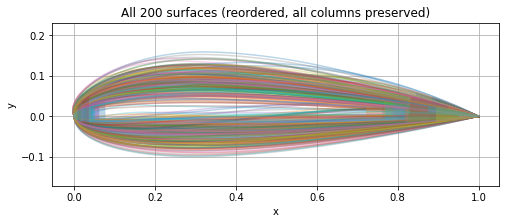

In [25]:
# Optional: quick visual check
plt.figure(figsize=(8, 3))
for df in surface_dfs_ordered:
    x = df.iloc[:, 0].to_numpy()
    y = df.iloc[:, 1].to_numpy()
    plt.plot(x, y, alpha=0.3)
plt.axis("equal")
plt.xlabel("x")
plt.ylabel("y")
plt.title("All 200 surfaces (reordered, all columns preserved)")
plt.grid(True)
plt.show()

### 🇪 Extracting the performance of the NACA profiles from the database (['name', 'F_p_x', 'F_p_y', 'F_v_x', 'F_v_y', 'F_tot_x', 'F_tot_y', 'CDp', 'CLp', 'CMp', 'CDv', 'CLv', 'CMv', 'CD', 'CL', 'CM', 'U_in', 'AoA']

In [26]:
#create the dataframe with all the forces and force coefficients
rows = []
for name in dataset_names:
    try:
        sim = af.Simulation(root=str(DATA_DIR_UNPACKED), name=name, T=298.15)

        # Forces (each a 2D vector)
        F_p, F_v, F_tot = sim.force()  # (Fx, Fy) for pressure / viscous / total

        # Coefficients: ((CDp, CLp, CMp), (CDv, CLv, CMv))
        (CDp, CLp, CMp), (CDv, CLv, CMv) = sim.force_coefficient()

        # Totals (pressure + viscous)
        CD, CL, CM = CDp + CDv, CLp + CLv, CMp + CMv

        rows.append({
            "name": name,
            "F_p_x": F_p[0],   "F_p_y": F_p[1],
            "F_v_x": F_v[0],   "F_v_y": F_v[1],
            "F_tot_x": F_tot[0], "F_tot_y": F_tot[1],
            "CDp": CDp, "CLp": CLp, "CMp": CMp,
            "CDv": CDv, "CLv": CLv, "CMv": CMv,
            "CD": CD, "CL": CL, "CM": CM,
        })
    except Exception as e:
        # Keep going even if a case fails
        rows.append({"name": name, "error": str(e)})

df_performance_airfoils = pd.DataFrame(rows)
# Optional: save results
# df_performance_airfoils.to_csv("airfrans_forces_coeffs.csv", index=False)
df_performance_airfoils


,name,F_p_x,F_p_y,F_v_x,F_v_y,F_tot_x,F_tot_y,CDp,CLp,CMp,CDv,CLv,CMv,CD,CL,CM
0,airFoil2D_SST_36.622_11.319_3.941_5.424_1.0_16...,-198.593791,1084.211029,-204.479102,1082.644957,5.885311,1.566072,0.022758,0.015102,0.007656,1.388165,1.387686,0.000479,1.410923,1.402788,0.008135
1,airFoil2D_SST_58.831_-3.563_2.815_4.916_10.078,9.706700,-127.125784,-4.729201,-126.631921,14.435901,-0.493863,0.008585,0.001537,0.007047,-0.061633,-0.061831,0.000197,-0.053049,-0.060293,0.007245
2,airFoil2D_SST_43.327_8.905_4.236_6.511_10.744,-228.679838,1578.976449,-236.595280,1577.514067,7.915442,1.462383,0.016645,0.009404,0.007241,1.435624,1.435426,0.000197,1.452268,1.444830,0.007438
3,airFoil2D_SST_89.151_4.462_0.974_4.094_1.0_19.856,-138.972680,2425.573678,-172.452008,2422.574875,33.479329,2.998803,0.010660,0.003516,0.007144,0.516280,0.516198,0.000082,0.526939,0.519714,0.007226
4,airFoil2D_SST_87.422_2.992_1.895_3.128_1.0_10.656,-69.252356,2048.182819,-99.804449,2046.709948,30.552092,1.472870,0.008344,0.001583,0.006761,0.452903,0.452931,-0.000027,0.461247,0.454514,0.006734
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,airFoil2D_SST_62.893_-0.786_3.167_0.0_17.071,20.032444,-182.750715,2.603707,-182.515191,17.428738,-0.235524,0.009625,0.002181,0.007444,-0.077923,-0.077924,0.000002,-0.068298,-0.075743,0.007446
196,airFoil2D_SST_32.677_5.679_0.493_6.223_1.0_9.86,-34.674920,416.508753,-39.453818,416.080294,4.778898,0.428460,0.010617,0.003027,0.007590,0.661131,0.661204,-0.000074,0.671748,0.664231,0.007517
197,airFoil2D_SST_83.061_-2.365_3.764_5.776_1.0_15.89,52.298224,359.850498,23.716628,360.417612,28.581596,-0.567114,0.009159,0.002161,0.006998,0.088565,0.088415,0.000150,0.097723,0.090575,0.007148
198,airFoil2D_SST_59.227_11.447_1.959_6.729_0.0_16...,-503.396966,2675.126610,-517.726731,2671.516146,14.329765,3.610464,0.018071,0.010963,0.007109,1.310761,1.310427,0.000335,1.328833,1.321390,0.007443


In [27]:
#adding the U_in and AoA to the columns of the dataframe df_performance_airfoils

# Extract parts of the name string
df_performance_airfoils[["U_in", "AoA"]] = df_performance_airfoils["name"].str.extract(r"SST_([-\d.]+)_([-\d.]+)")

# Convert to numeric (floats)
df_performance_airfoils["U_in"] = df_performance_airfoils["U_in"].astype(float)
df_performance_airfoils["AoA"] = df_performance_airfoils["AoA"].astype(float)

In [28]:
df_performance_airfoils

,name,F_p_x,F_p_y,F_v_x,F_v_y,F_tot_x,F_tot_y,CDp,CLp,CMp,CDv,CLv,CMv,CD,CL,CM,U_in,AoA
0,airFoil2D_SST_36.622_11.319_3.941_5.424_1.0_16...,-198.593791,1084.211029,-204.479102,1082.644957,5.885311,1.566072,0.022758,0.015102,0.007656,1.388165,1.387686,0.000479,1.410923,1.402788,0.008135,36.622,11.319
1,airFoil2D_SST_58.831_-3.563_2.815_4.916_10.078,9.706700,-127.125784,-4.729201,-126.631921,14.435901,-0.493863,0.008585,0.001537,0.007047,-0.061633,-0.061831,0.000197,-0.053049,-0.060293,0.007245,58.831,-3.563
2,airFoil2D_SST_43.327_8.905_4.236_6.511_10.744,-228.679838,1578.976449,-236.595280,1577.514067,7.915442,1.462383,0.016645,0.009404,0.007241,1.435624,1.435426,0.000197,1.452268,1.444830,0.007438,43.327,8.905
3,airFoil2D_SST_89.151_4.462_0.974_4.094_1.0_19.856,-138.972680,2425.573678,-172.452008,2422.574875,33.479329,2.998803,0.010660,0.003516,0.007144,0.516280,0.516198,0.000082,0.526939,0.519714,0.007226,89.151,4.462
4,airFoil2D_SST_87.422_2.992_1.895_3.128_1.0_10.656,-69.252356,2048.182819,-99.804449,2046.709948,30.552092,1.472870,0.008344,0.001583,0.006761,0.452903,0.452931,-0.000027,0.461247,0.454514,0.006734,87.422,2.992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,airFoil2D_SST_62.893_-0.786_3.167_0.0_17.071,20.032444,-182.750715,2.603707,-182.515191,17.428738,-0.235524,0.009625,0.002181,0.007444,-0.077923,-0.077924,0.000002,-0.068298,-0.075743,0.007446,62.893,-0.786
196,airFoil2D_SST_32.677_5.679_0.493_6.223_1.0_9.86,-34.674920,416.508753,-39.453818,416.080294,4.778898,0.428460,0.010617,0.003027,0.007590,0.661131,0.661204,-0.000074,0.671748,0.664231,0.007517,32.677,5.679
197,airFoil2D_SST_83.061_-2.365_3.764_5.776_1.0_15.89,52.298224,359.850498,23.716628,360.417612,28.581596,-0.567114,0.009159,0.002161,0.006998,0.088565,0.088415,0.000150,0.097723,0.090575,0.007148,83.061,-2.365
198,airFoil2D_SST_59.227_11.447_1.959_6.729_0.0_16...,-503.396966,2675.126610,-517.726731,2671.516146,14.329765,3.610464,0.018071,0.010963,0.007109,1.310761,1.310427,0.000335,1.328833,1.321390,0.007443,59.227,11.447


In [29]:
df_performance_airfoils["F_tot_x"].nsmallest(10)



130    2.945026
101    3.484419
138    4.011196
58     4.039052
34     4.125779
35     4.224364
187    4.522706
114    4.614433
196    4.778898
171    4.857841
Name: F_tot_x, dtype: float64

In [30]:
#checking if the names of the cases are the same, and the order is the same between the resampled cases and the coefficient/forces df
names_df = df_performance_airfoils['name'].reset_index(drop=True)
per_elem = names_df.eq(pd.Series(dataset_names))      # boolean Series per index
per_elem.tolist()                                     # -> [True, False, True, ...]


[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,

### 🇫 CST parametrization of the airfoils (to get a smooth prediction)

In [31]:
# ===============================
# CST utility functions
# ===============================

def class_function(x, N1=0.5, N2=1.0):
    """
    Class function C(x) = x^N1 * (1 - x)^N2 for airfoils.
    """
    x = np.clip(x, 1e-8, 1 - 1e-8)  # avoid exactly 0 or 1
    return np.power(x, N1) * np.power(1.0 - x, N2)


def bernstein_poly(i, N, x):
    """
    Bernstein polynomial B_i^N(x) = C(N,i) x^i (1-x)^(N-i).
    """
    from math import comb
    return comb(N, i) * np.power(x, i) * np.power(1.0 - x, N - i)


def cst_design_matrix(x, N, N1=0.5, N2=1.0):
    """
    Build design matrix M for CST:
        y(x) ≈ C(x) * Σ_i A_i B_i^N(x)
    Returns M of shape (len(x), N+1).
    """
    x = np.asarray(x)
    Cx = class_function(x, N1=N1, N2=N2)[:, None]  # (m, 1)
    B = np.stack([bernstein_poly(i, N, x) for i in range(N + 1)], axis=1)  # (m, N+1)
    return Cx * B  # elementwise product

def fit_cst_surface_unit(x, y, N=8, N1=0.5, N2=1.0):
    """
    Fit CST coefficients A for one surface y(x), assuming x is already
    normalized to [0, 1] (chord = 1, x_min = 0).

    Returns:
        coeffs: (N+1,) array of CST coefficients
    """
    x = np.asarray(x).astype(float)
    y = np.asarray(y).astype(float)

    # sanity clip in case of tiny numerical noise
    x_n = np.clip(x, 0.0, 1.0)

    # optional: drop exact endpoints if you like
    mask = (x_n > 1e-6) & (x_n < 1.0 - 1e-6)
    if mask.sum() < N + 1:
        x_fit = x_n
        y_fit = y
    else:
        x_fit = x_n[mask]
        y_fit = y[mask]

    M = cst_design_matrix(x_fit, N, N1=N1, N2=N2)  # (m, N+1)
    coeffs, *_ = np.linalg.lstsq(M, y_fit, rcond=None)

    return coeffs

In [32]:
# Getting the coefficients

# how many coeff do we wnat ...this is N-1...so in this case we will have 18 (9+9)
N_cst = 8

cst_coeffs_upper = []
cst_coeffs_lower = []

for df in surface_dfs_ordered:
    x = df["x"].to_numpy()
    y = df["y"].to_numpy()

    # split using the LE index (since surface_dfs_ordered is TE->LE->TE)
    le_idx = np.argmin(x)
    x_u, y_u = x[:le_idx+1], y[:le_idx+1]   # upper: TE -> LE
    x_l, y_l = x[le_idx:],   y[le_idx:]     # lower: LE -> TE

    a_u = fit_cst_surface_unit(x_u, y_u, N=N_cst)
    a_l = fit_cst_surface_unit(x_l, y_l, N=N_cst)

    cst_coeffs_upper.append(a_u)
    cst_coeffs_lower.append(a_l)

cst_coeffs_upper = np.stack(cst_coeffs_upper)
cst_coeffs_lower = np.stack(cst_coeffs_lower)
cst_all = np.concatenate([cst_coeffs_upper, cst_coeffs_lower], axis=1)

print("Upper CST coeffs:", cst_coeffs_upper.shape)
print("Lower CST coeffs:", cst_coeffs_lower.shape)
print("Combined CST representation:", cst_all.shape)
print("CST raw min:", cst_all.min())
print("CST raw max:", cst_all.max())
print("Per-coefficient max:", cst_all.max(axis=0))

Upper CST coeffs: (200, 9)
Lower CST coeffs: (200, 9)
Combined CST representation: (200, 18)
CST raw min: -4.90852027723755
CST raw max: 4.712739284458004
Per-coefficient max: [0.57844841 0.39992284 1.89378383 0.4291194  4.25994801 0.63888406
 3.94876337 0.57273256 1.77615965 0.2808275  0.24845552 3.09621012
 2.48334524 4.71273928 3.14440037 2.0979792  1.24354315 0.55311967]


### 🇬 Check the CST coefficients with plot

In [33]:
def reconstruct_airfoil_from_cst_unit(coeffs, N_cst, N1=0.5, N2=1.0, n_points_per_side=200):
    """
    coeffs: (2*(N_cst+1),) = [Au_0..N, Al_0..N]
    Returns x_all, y_all with x in [0,1], closed loop TE->LE->TE.
    """
    coeffs = np.asarray(coeffs).ravel()
    Au = coeffs[:N_cst+1]
    Al = coeffs[N_cst+1:]

    x_n = np.linspace(0.0, 1.0, n_points_per_side)
    M   = cst_design_matrix(x_n, N_cst, N1=N1, N2=N2)

    y_u = M @ Au
    y_l = M @ Al

    # build loop: TE->LE (upper), LE->TE (lower)
    x_upper = x_n[::-1]
    y_upper = y_u[::-1]
    x_lower = x_n
    y_lower = y_l

    x_all = np.concatenate([x_upper, x_lower])
    y_all = np.concatenate([y_upper, y_lower])

    return x_all, y_all


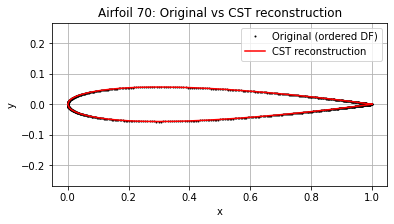

In [34]:
i = 70  # or any index
df_orig = surface_dfs_ordered[i]
x_orig = df_orig["x"].to_numpy()
y_orig = df_orig["y"].to_numpy()

coeffs_i = cst_all[i]

x_cst, y_cst = reconstruct_airfoil_from_cst_unit(coeffs_i, N_cst=N_cst)

plt.figure(figsize=(6, 3))
plt.plot(x_orig, y_orig, "k.", ms=2, label="Original (ordered DF)")
plt.plot(x_cst,  y_cst,  "r-", lw=1.5, label="CST reconstruction")
plt.axis("equal")
plt.xlabel("x")
plt.ylabel("y")
plt.title(f"Airfoil {i}: Original vs CST reconstruction")
plt.legend()
plt.grid(True)
plt.savefig(f"Airfoil_{i}_Original_vs_CST_reconstruction.png", dpi=120, bbox_inches='tight', facecolor='white')
plt.show()


### 🇭 Building the Autoencoder


<img src="autoencoder_template.png" width="800">


In [35]:
# data for autoencoder : only the CST coeffs...this is the data that will change when we use the decoder part at the end.
# cst_all - this df holds the data and we have 18 points corresponding to each profile
cst_all[0]

array([ 0.37527325,  0.22644242,  0.63681694, -0.19116867,  1.04847747,
       -0.65310495,  1.23212857, -0.55480921,  0.87422739,  0.18475011,
       -1.30643559,  2.7716185 , -4.4574437 ,  4.24333128, -2.6687114 ,
        0.29285001,  0.3477321 , -0.03335218])

In [36]:
#autoencoder that goes from 200x18 to 200x6 and then back to the initial 200x18.

**Step 1: Building the dataset for the autoencoder**

In [37]:
# Split data into 80% train, 20% validation
train_idx, val_idx = train_test_split(np.arange(200), test_size=0.2, random_state=42)
print(f"Training samples: {len(train_idx)}")
print(f"Validation samples: {len(val_idx)}")

Training samples: 160
Validation samples: 40


In [38]:
# Split CST data
cst_train = cst_all[train_idx]
cst_val = cst_all[val_idx]

# Standardize using TRAINING data only
cst_all_mean = cst_train.mean(axis=0, keepdims=True)
cst_all_std  = cst_train.std(axis=0, keepdims=True) + 1e-8

cst_train_standardized = (cst_train - cst_all_mean) / cst_all_std
cst_val_standardized = (cst_val - cst_all_mean) / cst_all_std

# Create tensors for training and validation
X_train = torch.tensor(cst_train_standardized, dtype=torch.float32)
X_val = torch.tensor(cst_val_standardized, dtype=torch.float32)

# For compatibility with existing code, keep X as the full dataset for now
# This will be used in sections that reference all 200 samples
cst_all_standardized = (cst_all - cst_all_mean) / cst_all_std
X = torch.tensor(cst_all_standardized, dtype=torch.float32)

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")

X_train shape: torch.Size([160, 18])
X_val shape: torch.Size([40, 18])


**Step 2: Defining the autoencoder - it goes from 200x18 to 200x6 and then back to the initial 200x18**

In [39]:
class AirfoilAutoencoder(nn.Module):
    def __init__(self, in_dim=18, latent_dim=6, hidden_dim=10):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, in_dim)
        )

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z = self.encode(x)
        x_recon = self.decode(z)
        return x_recon, z


**Step 3: Training loop**

In [40]:
# Wrap into DataLoaders
train_dataset = TensorDataset(X_train, X_train)
val_dataset = TensorDataset(X_val, X_val)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Model, loss, optimizer
model_autoencoder = AirfoilAutoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model_autoencoder.parameters(), lr=1e-3)

# Training with validation
n_epochs = 500
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    # Training phase
    model_autoencoder.train()
    total_loss = 0.0
    for xb, _ in train_loader:
        optimizer.zero_grad()
        x_recon, z = model_autoencoder(xb)
        loss = criterion(x_recon, xb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    
    train_loss = total_loss / len(train_dataset)
    train_losses.append(train_loss)
    
    # Validation phase
    model_autoencoder.eval()
    val_total_loss = 0.0
    with torch.no_grad():
        for xb_val, _ in val_loader:
            x_recon_val, z_val = model_autoencoder(xb_val)
            val_loss_batch = criterion(x_recon_val, xb_val)
            val_total_loss += val_loss_batch.item() * xb_val.size(0)
    
    val_loss = val_total_loss / len(val_dataset)
    val_losses.append(val_loss)
    
    if epoch % 50 == 0 or epoch == n_epochs - 1:
        print(f"Epoch {epoch:3d} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

print(f"\nFinal Training Loss: {train_losses[-1]:.6f}")
print(f"Final Validation Loss: {val_losses[-1]:.6f}")
print(f"Val/Train Ratio: {val_losses[-1]/train_losses[-1]:.3f}")

Epoch   0 | Train Loss: 1.040834 | Val Loss: 1.060562
Epoch  50 | Train Loss: 0.104448 | Val Loss: 0.086550
Epoch 100 | Train Loss: 0.061465 | Val Loss: 0.050631
Epoch 150 | Train Loss: 0.031537 | Val Loss: 0.032235
Epoch 200 | Train Loss: 0.015976 | Val Loss: 0.020284
Epoch 250 | Train Loss: 0.013113 | Val Loss: 0.017234
Epoch 300 | Train Loss: 0.012008 | Val Loss: 0.016207
Epoch 350 | Train Loss: 0.010581 | Val Loss: 0.015213
Epoch 400 | Train Loss: 0.009645 | Val Loss: 0.013572
Epoch 450 | Train Loss: 0.008764 | Val Loss: 0.012696
Epoch 499 | Train Loss: 0.008105 | Val Loss: 0.011871

Final Training Loss: 0.008105
Final Validation Loss: 0.011871
Val/Train Ratio: 1.465


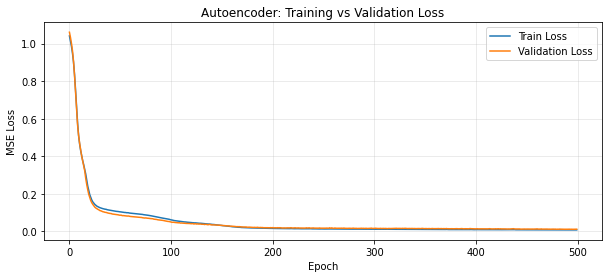

In [41]:
# Plot training curves
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label='Train Loss', linewidth=1.5)
plt.plot(val_losses, label='Validation Loss', linewidth=1.5)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Autoencoder: Training vs Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

**Step 4: Getting the Latent Representation**

In [42]:
model_autoencoder.eval() # switch to eval behavior
with torch.no_grad():
    latent = model_autoencoder.encoder(X)  # shape (200, 6)
print(latent.shape)


torch.Size([200, 6])


In [43]:
X.shape

torch.Size([200, 18])

**Step 5: Checking autoencoder - plot original vs reconstruction**

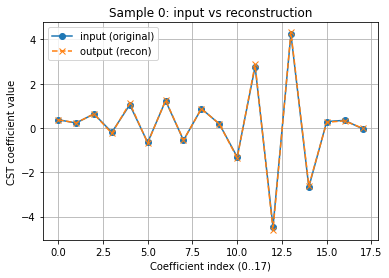

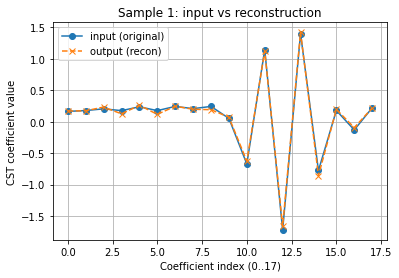

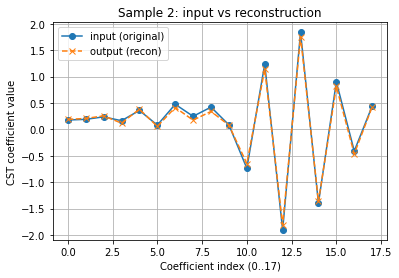

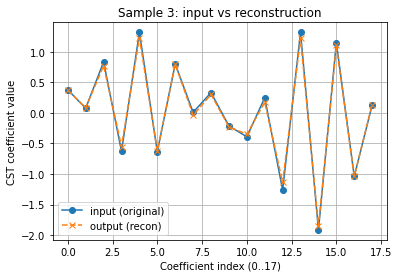

In [44]:
model_autoencoder.eval()

# pick some samples to visualize
idxs = [0, 1, 2, 3]
xb = X[idxs]  # shape: [B, 18]

with torch.no_grad():
    out = model_autoencoder(xb)
    # handle both cases: forward -> recon OR forward -> (recon, z)
    if isinstance(out, tuple):
        recon, z = out
    else:
        recon = out

# move to numpy (still standardized)
xb_np    = xb.cpu().numpy()       # input to AE
recon_np = recon.cpu().numpy()    # output of AE

# unstandardize to get actual CST coefficients (optional but nicer to interpret)
xb_cst    = xb_np    * cst_all_std + cst_all_mean   # shape [B, 18]
recon_cst = recon_np * cst_all_std + cst_all_mean   # shape [B, 18]

def plot_coeffs_overlay(orig, rec, idx=None):
    """
    orig, rec: arrays of shape (18,)
    Plots the 18 CST coefficients (upper+lower) for input vs reconstruction.
    """
    n = orig.shape[0]
    coef_idx = np.arange(n)

    plt.figure()
    plt.plot(coef_idx, orig,  marker='o', label='input (original)')
    plt.plot(coef_idx, rec,   marker='x', linestyle='--', label='output (recon)')
    plt.xlabel("Coefficient index (0..17)")
    plt.ylabel("CST coefficient value")
    title = f"Sample {idx}: input vs reconstruction" if idx is not None else "Input vs reconstruction"
    plt.title(title)
    plt.legend()
    #plt.xlim(0,13)
    #plt.ylim(-1,1)
    plt.grid(True)

    # ---- save figure ----
    if idx is not None:
        filename = f"cst_coeffs_sample_{idx}.png"
    else:
        filename = "cst_coeffs_sample.png"
    plt.savefig(filename, dpi=120, bbox_inches='tight', facecolor='white')
    # ---------------------
    
    plt.show()

for j, idx in enumerate(idxs):
    plot_coeffs_overlay(xb_cst[j], recon_cst[j], idx=idx)


### 🇮 Building and training of the inverse network

**Train Inverse Network**

**Step 1: Building the dataset for the inverse neural network**

In [45]:
df_performance_airfoils

,name,F_p_x,F_p_y,F_v_x,F_v_y,F_tot_x,F_tot_y,CDp,CLp,CMp,CDv,CLv,CMv,CD,CL,CM,U_in,AoA
0,airFoil2D_SST_36.622_11.319_3.941_5.424_1.0_16...,-198.593791,1084.211029,-204.479102,1082.644957,5.885311,1.566072,0.022758,0.015102,0.007656,1.388165,1.387686,0.000479,1.410923,1.402788,0.008135,36.622,11.319
1,airFoil2D_SST_58.831_-3.563_2.815_4.916_10.078,9.706700,-127.125784,-4.729201,-126.631921,14.435901,-0.493863,0.008585,0.001537,0.007047,-0.061633,-0.061831,0.000197,-0.053049,-0.060293,0.007245,58.831,-3.563
2,airFoil2D_SST_43.327_8.905_4.236_6.511_10.744,-228.679838,1578.976449,-236.595280,1577.514067,7.915442,1.462383,0.016645,0.009404,0.007241,1.435624,1.435426,0.000197,1.452268,1.444830,0.007438,43.327,8.905
3,airFoil2D_SST_89.151_4.462_0.974_4.094_1.0_19.856,-138.972680,2425.573678,-172.452008,2422.574875,33.479329,2.998803,0.010660,0.003516,0.007144,0.516280,0.516198,0.000082,0.526939,0.519714,0.007226,89.151,4.462
4,airFoil2D_SST_87.422_2.992_1.895_3.128_1.0_10.656,-69.252356,2048.182819,-99.804449,2046.709948,30.552092,1.472870,0.008344,0.001583,0.006761,0.452903,0.452931,-0.000027,0.461247,0.454514,0.006734,87.422,2.992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,airFoil2D_SST_62.893_-0.786_3.167_0.0_17.071,20.032444,-182.750715,2.603707,-182.515191,17.428738,-0.235524,0.009625,0.002181,0.007444,-0.077923,-0.077924,0.000002,-0.068298,-0.075743,0.007446,62.893,-0.786
196,airFoil2D_SST_32.677_5.679_0.493_6.223_1.0_9.86,-34.674920,416.508753,-39.453818,416.080294,4.778898,0.428460,0.010617,0.003027,0.007590,0.661131,0.661204,-0.000074,0.671748,0.664231,0.007517,32.677,5.679
197,airFoil2D_SST_83.061_-2.365_3.764_5.776_1.0_15.89,52.298224,359.850498,23.716628,360.417612,28.581596,-0.567114,0.009159,0.002161,0.006998,0.088565,0.088415,0.000150,0.097723,0.090575,0.007148,83.061,-2.365
198,airFoil2D_SST_59.227_11.447_1.959_6.729_0.0_16...,-503.396966,2675.126610,-517.726731,2671.516146,14.329765,3.610464,0.018071,0.010963,0.007109,1.310761,1.310427,0.000335,1.328833,1.321390,0.007443,59.227,11.447


In [46]:
# Creating the scalars input for the NN ( "F_tot_x", "F_tot_y", "CD", "CL", "CM")

# getting only the needed columns
X_scalars_df = df_performance_airfoils[["F_tot_x", "F_tot_y", "CD", "CL", "CM", "U_in", "AoA"]]
# creating the numpy array for computation
X_scalars = X_scalars_df.to_numpy(dtype=np.float32)   # shape: (200, 7)

# Handle NaNs (if any)
X_scalars = np.nan_to_num(X_scalars, nan=0.0, posinf=0.0, neginf=0.0)

# Split into train/val
X_scalars_train = X_scalars[train_idx]
X_scalars_val = X_scalars[val_idx]

# Standardize using TRAINING data only
sc_mean = X_scalars_train.mean(axis=0, keepdims=True)
sc_std  = X_scalars_train.std(axis=0, keepdims=True) + 1e-8

X_scalars_train_std = (X_scalars_train - sc_mean) / sc_std
X_scalars_val_std = (X_scalars_val - sc_mean) / sc_std

# For compatibility, also create standardized version of full dataset
X_scalars_std = (X_scalars - sc_mean) / sc_std

# Convert to torch
X_sc_train_t = torch.tensor(X_scalars_train_std, dtype=torch.float32)
X_sc_val_t = torch.tensor(X_scalars_val_std, dtype=torch.float32)
X_sc_t = torch.tensor(X_scalars_std, dtype=torch.float32)  # For compatibility

print(f"X_sc_train_t shape: {X_sc_train_t.shape}")
print(f"X_sc_val_t shape: {X_sc_val_t.shape}")

X_sc_train_t shape: torch.Size([160, 7])
X_sc_val_t shape: torch.Size([40, 7])


In [47]:
# Creating the p_over_rho vector input for the NN ( "p_over_rho") - pressure contour on the airfoil 1000 points
# taking only the columns with "p_over_rho" from the resampled_df_list
p_over_rho_list = [df["p_over_rho"] for df in surface_dfs_ordered]



# suppose your list is called `dfs`
# each element is a DataFrame with ONE column (the signal)

target_len = 1000
resampled_p_over_rho_list = []

for s in p_over_rho_list:
    # take the only column (or the first column)
    s = pd.Series(s)          # Series
    col_name = s.name          # keep the column name

    # original "x" positions, normalized 0–1
    old_x = np.linspace(0, 1, len(s))
    # new "x" positions with exactly 1000 samples
    new_x = np.linspace(0, 1, target_len)

    # interpolate values to new_x
    new_values = np.interp(new_x, old_x, s.values)

    resampled_p_over_rho_list.append(new_values.astype(np.float32))  # 1D, not DF

#stack them into numpy array
X_p_over_rho = np.stack(resampled_p_over_rho_list).astype(np.float32) # (200 x 1000)

# Split into train/val
X_p_over_rho_train = X_p_over_rho[train_idx]
X_p_over_rho_val = X_p_over_rho[val_idx]

# Standardize using TRAINING data only
prho_mean = X_p_over_rho_train.mean(axis=0, keepdims=True)
prho_std  = X_p_over_rho_train.std(axis=0, keepdims=True) + 1e-8

X_p_over_rho_train_std = (X_p_over_rho_train - prho_mean) / prho_std
X_p_over_rho_val_std = (X_p_over_rho_val - prho_mean) / prho_std
X_p_over_rho_std = (X_p_over_rho - prho_mean) / prho_std  # For compatibility

# Convert to torch tensor
X_p_over_rho_train_t = torch.tensor(X_p_over_rho_train_std, dtype=torch.float32)
X_p_over_rho_val_t = torch.tensor(X_p_over_rho_val_std, dtype=torch.float32)
X_p_over_rho_t = torch.tensor(X_p_over_rho_std, dtype=torch.float32)  # For compatibility

print(f"X_p_over_rho_train_t shape: {X_p_over_rho_train_t.shape}")
print(f"X_p_over_rho_val_t shape: {X_p_over_rho_val_t.shape}")


X_p_over_rho_train_t shape: torch.Size([160, 1000])
X_p_over_rho_val_t shape: torch.Size([40, 1000])


In [48]:
# Get latent codes for train and val separately
model_autoencoder.eval()
with torch.no_grad():
    latent_train = model_autoencoder.encoder(X_train)
    latent_val = model_autoencoder.encoder(X_val)
    latent = model_autoencoder.encoder(X)  # Full for compatibility

# Standardize using TRAINING latent only
mean_latent = latent_train.mean(dim=0, keepdim=True)
std_latent  = latent_train.std(dim=0, unbiased=False, keepdim=True)

latent_train_standardized = (latent_train - mean_latent) / (std_latent + 1e-8)
latent_val_standardized = (latent_val - mean_latent) / (std_latent + 1e-8)
latent_standardized = (latent - mean_latent) / (std_latent + 1e-8)  # Full for compatibility

print(f"latent_train_standardized shape: {latent_train_standardized.shape}")
print(f"latent_val_standardized shape: {latent_val_standardized.shape}")

latent_train_standardized shape: torch.Size([160, 6])
latent_val_standardized shape: torch.Size([40, 6])


In [49]:
latent_standardized.shape

torch.Size([200, 6])

**Step 2: Defining the NN**

In [50]:
class SimpleLatentMLP(nn.Module):
    def __init__(self, sc_dim=7, cp_dim=1000, lat_dim=6, h1=1024, h2=1024):
        super().__init__()
        in_dim = sc_dim + cp_dim
        self.net = nn.Sequential(
            nn.Linear(in_dim, h1),
            nn.ReLU(),
            nn.Linear(h1, h2),
            nn.ReLU(),
            nn.Linear(h2, lat_dim)
        )

    def forward(self, x_sc, x_cp):
        if x_sc.dim() == 1: x_sc = x_sc.unsqueeze(0)
        if x_cp.dim() == 1: x_cp = x_cp.unsqueeze(0)

        #print("x_sc.shape:", x_sc.shape)
        #print("x_cp.shape:", x_cp.shape)
        
        x = torch.cat([x_cp, x_sc], dim=-1)  # concat on feature axis
        return self.net(x)



**Step 3: Training the NN**

In [51]:

# ---- config ----
EPOCHS = 300
BATCH_SIZE = 16
LR = 1e-4
WEIGHT_DECAY = 1e-2  # small L2 helps with 200 samples

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Put data on device - TRAIN and VAL
X_sc_train_t = X_sc_train_t.to(device).float()
X_p_over_rho_train_t = X_p_over_rho_train_t.to(device).float()
Y_latent_train = latent_train_standardized.to(device).float()

X_sc_val_t = X_sc_val_t.to(device).float()
X_p_over_rho_val_t = X_p_over_rho_val_t.to(device).float()
Y_latent_val = latent_val_standardized.to(device).float()

# Also keep full dataset for compatibility
X_sc_t = X_sc_t.to(device).float()
X_p_over_rho_t = X_p_over_rho_t.to(device).float()
Y_latent = latent_standardized.to(device).float()

# Dataloaders
train_ds = TensorDataset(X_sc_train_t, X_p_over_rho_train_t, Y_latent_train)
val_ds = TensorDataset(X_sc_val_t, X_p_over_rho_val_t, Y_latent_val)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

# Model, loss, optim
model = SimpleLatentMLP(sc_dim=7, cp_dim=1000, lat_dim=6).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

# ---- train with validation ----
train_losses = []
val_losses = []

for epoch in range(1, EPOCHS + 1):
    # Training
    model.train()
    running = 0.0
    for scb, cpb, yb in train_loader:
        optimizer.zero_grad(set_to_none=True)
        z_pred = model(scb, cpb)
        loss = criterion(z_pred, yb)
        loss.backward()
        optimizer.step()
        running += loss.item() * scb.size(0)
    
    train_loss = running / len(train_ds)
    train_losses.append(train_loss)
    
    # Validation
    model.eval()
    val_running = 0.0
    with torch.no_grad():
        for scb_val, cpb_val, yb_val in val_loader:
            z_pred_val = model(scb_val, cpb_val)
            val_loss_batch = criterion(z_pred_val, yb_val)
            val_running += val_loss_batch.item() * scb_val.size(0)
    
    val_loss = val_running / len(val_ds)
    val_losses.append(val_loss)
    
    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch:03d} | Train MSE: {train_loss:.6f} | Val MSE: {val_loss:.6f}")

print(f"\nFinal Training Loss: {train_losses[-1]:.6f}")
print(f"Final Validation Loss: {val_losses[-1]:.6f}")
print(f"Val/Train Ratio: {val_losses[-1]/train_losses[-1]:.3f}")

# ---- inference on all 200 ----
model.eval()
with torch.no_grad():
    Z_hat = model(X_sc_t, X_p_over_rho_t)  # (200, 6)
print("Z_hat shape:", Z_hat.shape)

# (optional) save
#torch.save(model.state_dict(), "simple_latent_mlp.pt")

Epoch 001 | Train MSE: 0.910744 | Val MSE: 0.867826
Epoch 010 | Train MSE: 0.436633 | Val MSE: 0.677215
Epoch 020 | Train MSE: 0.301555 | Val MSE: 0.553768
Epoch 030 | Train MSE: 0.240749 | Val MSE: 0.457829
Epoch 040 | Train MSE: 0.190566 | Val MSE: 0.483201
Epoch 050 | Train MSE: 0.152462 | Val MSE: 0.489784
Epoch 060 | Train MSE: 0.136287 | Val MSE: 0.499984
Epoch 070 | Train MSE: 0.106817 | Val MSE: 0.474232
Epoch 080 | Train MSE: 0.104266 | Val MSE: 0.536625
Epoch 090 | Train MSE: 0.088024 | Val MSE: 0.447230
Epoch 100 | Train MSE: 0.092139 | Val MSE: 0.417069
Epoch 110 | Train MSE: 0.084398 | Val MSE: 0.436426
Epoch 120 | Train MSE: 0.102913 | Val MSE: 0.404511
Epoch 130 | Train MSE: 0.060911 | Val MSE: 0.425104
Epoch 140 | Train MSE: 0.084833 | Val MSE: 0.531541
Epoch 150 | Train MSE: 0.053856 | Val MSE: 0.500129
Epoch 160 | Train MSE: 0.064734 | Val MSE: 0.492957
Epoch 170 | Train MSE: 0.065551 | Val MSE: 0.453931
Epoch 180 | Train MSE: 0.044539 | Val MSE: 0.477673
Epoch 190 | 

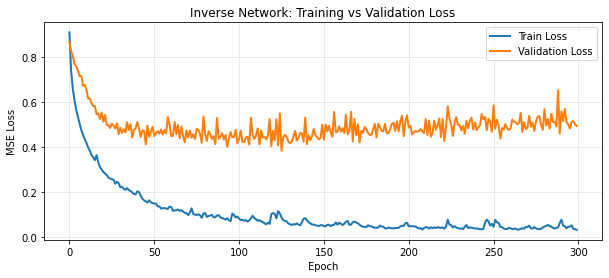

In [52]:
# Plot inverse network training curves
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Inverse Network: Training vs Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### 🇯 Combine the prediction from the inverse NN with the decoder to generate the new 2D aifoil geometry that will achieve the ideal set of performance parameters

**Step 1: Create an ideal set of performance parameters**

In [53]:
X_scalars_df

,F_tot_x,F_tot_y,CD,CL,CM,U_in,AoA
0,5.885311,1.566072,1.410923,1.402788,0.008135,36.622,11.319
1,14.435901,-0.493863,-0.053049,-0.060293,0.007245,58.831,-3.563
2,7.915442,1.462383,1.452268,1.444830,0.007438,43.327,8.905
3,33.479329,2.998803,0.526939,0.519714,0.007226,89.151,4.462
4,30.552092,1.472870,0.461247,0.454514,0.006734,87.422,2.992
...,...,...,...,...,...,...,...
195,17.428738,-0.235524,-0.068298,-0.075743,0.007446,62.893,-0.786
196,4.778898,0.428460,0.671748,0.664231,0.007517,32.677,5.679
197,28.581596,-0.567114,0.097723,0.090575,0.007148,83.061,-2.365
198,14.329765,3.610464,1.328833,1.321390,0.007443,59.227,11.447


In [54]:
# creating a new "good" set of scalars for prediction
proposed = {
    "F_tot_x": X_scalars_df["F_tot_x"].min(),
    "F_tot_y": X_scalars_df["F_tot_y"].max(),
    "CD": X_scalars_df["CD"].min(),
    "CL": X_scalars_df["CL"].max(),
    "CM": X_scalars_df.loc[(X_scalars_df["CM"] - (-0.05)).abs().idxmin(), "CM"],   # closest to -0.05
    "U_in": X_scalars_df["U_in"].min(),
    "AoA": X_scalars_df.loc[(X_scalars_df["AoA"] - 5).abs().idxmin(), "AoA"],      # closest to 5
}

X_scalars_df_proposed = pd.DataFrame([proposed])


# creating the numpy array for computation
X_scalars_proposed = X_scalars_df_proposed.to_numpy(dtype=np.float32)   

# Handle NaNs (if any)
X_scalars_proposed = np.nan_to_num(X_scalars_proposed, nan=0.0, posinf=0.0, neginf=0.0)

# Standardize per feature (fit on train split in real use)
sc_mean_proposed = X_scalars_proposed.mean(axis=0, keepdims=True)
sc_std_proposed  = X_scalars_proposed.std(axis=0, keepdims=True) + 1e-8
X_scalars_proposed_std = (X_scalars_proposed - sc_mean_proposed) / sc_std_proposed

# Convert to torch tensor
X_sc_proposed_t = torch.tensor(X_scalars_proposed_std, dtype=torch.float32)  # shape: (1, 7)

In [55]:
# creating a new "good" set of pressures for prediction
# for simplicity I'll just take the first set in our 200 dataset
X_p_over_rho_proposed = X_p_over_rho[5]


# Standardize per feature (fit on train split in real use)
prho_mean_proposed = X_p_over_rho_proposed.mean(axis=0, keepdims=True)
prho_std_proposed  = X_p_over_rho_proposed.std(axis=0, keepdims=True) + 1e-8
X_p_over_rho_proposed_std = (X_p_over_rho_proposed - prho_mean_proposed) / prho_std_proposed

# Convert to torch tensor
X_p_over_rho_proposed_t = torch.tensor(X_p_over_rho_proposed_std, dtype=torch.float32)  # shape: (1, 1000)

**Step 2: Predict the latent space for those parameters with the inverse NN**

In [56]:
# Move inputs to the same device as the model
X_sc_proposed_t = X_sc_proposed_t.to(device)
X_p_over_rho_proposed_t = X_p_over_rho_proposed_t.to(device)

# Also move mean and std to GPU
std_latent = std_latent.to(device)
mean_latent = mean_latent.to(device)

with torch.no_grad():
     Z_hat_proposed = model(X_sc_proposed_t, X_p_over_rho_proposed_t)  # (1, 6)
print("Z_hat_proposed shape:", Z_hat_proposed.shape)

#DEstandardization of the predicted latent space
latent_reconstructed = Z_hat_proposed * std_latent + mean_latent


Z_hat_proposed shape: torch.Size([1, 6])


**Step 3: Use the predicted latent space with the decoder to generate new 2D airfoil geometry**

In [57]:
model_autoencoder.to(device).eval()

with torch.no_grad():
    cst_coeff_predicted = model_autoencoder.decoder(latent_reconstructed)  # -> [B, 18]

In [58]:
cst_coeff_predicted

tensor([[-0.3064, -0.6546, -0.0757, -0.2541,  0.0537, -0.3200,  0.1349, -0.5495,
         -0.0138,  0.0815,  0.0328,  0.1126, -0.0557, -0.0622,  0.3094, -0.6673,
          0.6923, -1.0769]])

In [59]:
#Convert mean/std to GPU tensors
cst_all_mean = torch.tensor(cst_all_mean, dtype=torch.float32).to(device)
cst_all_std = torch.tensor(cst_all_std, dtype=torch.float32).to(device)

# denormalization
cst_coeff_pred_denorm = (cst_coeff_predicted * cst_all_std + cst_all_mean).cpu().numpy()


In [60]:
# getting the x and y for the predicted CST coeffs
x_predicted, y_predicted = reconstruct_airfoil_from_cst_unit(cst_coeff_pred_denorm, N_cst=N_cst)

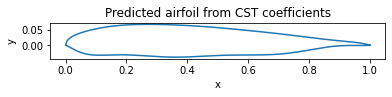

In [61]:
i = 100  # or any index
df_orig = surface_dfs_ordered[i]
x_orig = df_orig["x"].to_numpy()
y_orig = df_orig["y"].to_numpy()

coeffs_i = cst_all[i]



plt.figure()
plt.plot(x_predicted, y_predicted)
#plt.plot(x_orig, y_orig, "k.", ms=2, label="Original (ordered DF)")
plt.gca().set_aspect("equal", adjustable="box")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Predicted airfoil from CST coefficients")
plt.show()


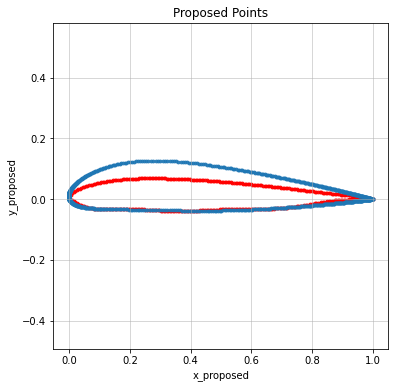

In [62]:
# plotting the resulted airfoil geometry
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x_predicted, y_predicted, s=8, alpha=0.9, color="red")
ax.scatter(surface_dfs_ordered[0]["x"], surface_dfs_ordered[0]["y"], s=8, alpha=0.9)

ax.set_xlabel("x_proposed")
ax.set_ylabel("y_proposed")
ax.set_title("Proposed Points")
ax.set_aspect("equal", adjustable="datalim")  # keep aspect ratio
ax.grid(True, linewidth=0.5)
plt.savefig("NACA_pred9.png", dpi=120, bbox_inches='tight', transparent=False, facecolor='white')
plt.show()


**Plot PCA(first 2 components) and overlay z_pred to see if they are on the same manifold**

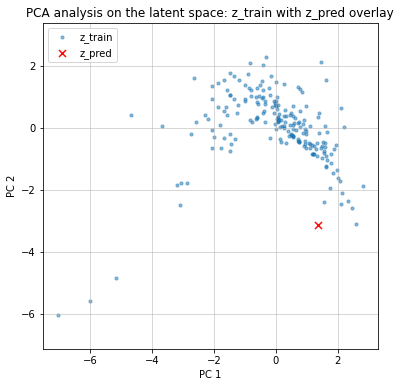

In [63]:
# Convert to numpy
z_train_std = latent_standardized.detach().cpu().numpy()
z_pred_std  = latent_reconstructed.detach().cpu().numpy()
if z_pred_std.ndim == 1:
    z_pred_std = z_pred_std[None, :]  # ensure 2D

def overlay_2d(emb_train, emb_pred, title, xlabel="PC 1", ylabel="PC 2",
               train_label="z_train", pred_label="z_pred"):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(emb_train[:, 0], emb_train[:, 1], s=10, alpha=0.5, label=train_label)
    ax.scatter(emb_pred[:, 0],  emb_pred[:, 1],  s=50, c="red", alpha=0.95, marker='x', label=pred_label)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_aspect("equal", adjustable="datalim")
    ax.grid(True, linewidth=0.5)
    ax.legend()
    plt.savefig("PCA_latent_space.png", dpi=120, bbox_inches='tight', facecolor='white')
    plt.show()

# --- PCA(2) ---
pca = PCA(n_components=2, random_state=0).fit(z_train_std)
pca_train = pca.transform(z_train_std)
pca_pred  = pca.transform(z_pred_std)
overlay_2d(pca_train, pca_pred, "PCA analysis on the latent space: z_train with z_pred overlay")

